In [1]:
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
train_df = pd.read_csv("wind-turbine/train.csv")

## Data Preparation

In [3]:
train_df.shape

(28200, 22)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tracking_id                     28200 non-null  object 
 1   datetime                        28200 non-null  object 
 2   wind_speed(m/s)                 27927 non-null  float64
 3   atmospheric_temperature(°C)     24750 non-null  float64
 4   shaft_temperature(°C)           28198 non-null  float64
 5   blades_angle(°)                 27984 non-null  float64
 6   gearbox_temperature(°C)         28199 non-null  float64
 7   engine_temperature(°C)          28188 non-null  float64
 8   motor_torque(N-m)               28176 non-null  float64
 9   generator_temperature(°C)       28188 non-null  float64
 10  atmospheric_pressure(Pascal)    25493 non-null  float64
 11  area_temperature(°C)            28200 non-null  float64
 12  windmill_body_temperature(°C)   

In [5]:
numerical_columns = train_df.describe().columns.values

In [6]:
categorical_columns = ["turbine_status", "cloud_level"]

In [7]:
train_df.describe().T.style.bar(subset=['mean'])

,count,mean,std,min,25%,50%,75%,max
wind_speed(m/s),27927.000000,69.037071,76.275645,-496.211029,20.883502,93.302129,95.268058,601.455670
atmospheric_temperature(°C),24750.000000,0.383727,44.278534,-99.000000,7.948900,16.102410,23.687285,80.217444
shaft_temperature(°C),28198.000000,40.085387,27.204430,-99.000000,41.633238,43.686082,45.673685,169.820455
blades_angle(°),27984.000000,-9.654038,47.918161,-146.259543,-1.197652,-0.495608,5.495030,165.932123
gearbox_temperature(°C),28199.000000,41.027755,43.663605,-244.974098,40.557952,43.221735,45.879425,999.000000
engine_temperature(°C),28188.000000,42.614239,6.124546,3.167151,41.911365,43.525297,45.174246,50.000000
motor_torque(N-m),28176.000000,1710.819803,827.205537,500.000000,870.340239,2031.849540,2462.585729,3000.000000
generator_temperature(°C),28188.000000,65.027857,19.816499,33.893779,41.198509,70.729533,78.945849,100.000000
atmospheric_pressure(Pascal),25493.000000,53185.064883,187503.615642,-1188624.131412,16794.921490,18191.125867,118113.289822,1272551.895262
area_temperature(°C),28200.000000,32.735091,7.703391,-30.000000,27.311644,32.605195,38.232387,55.000000


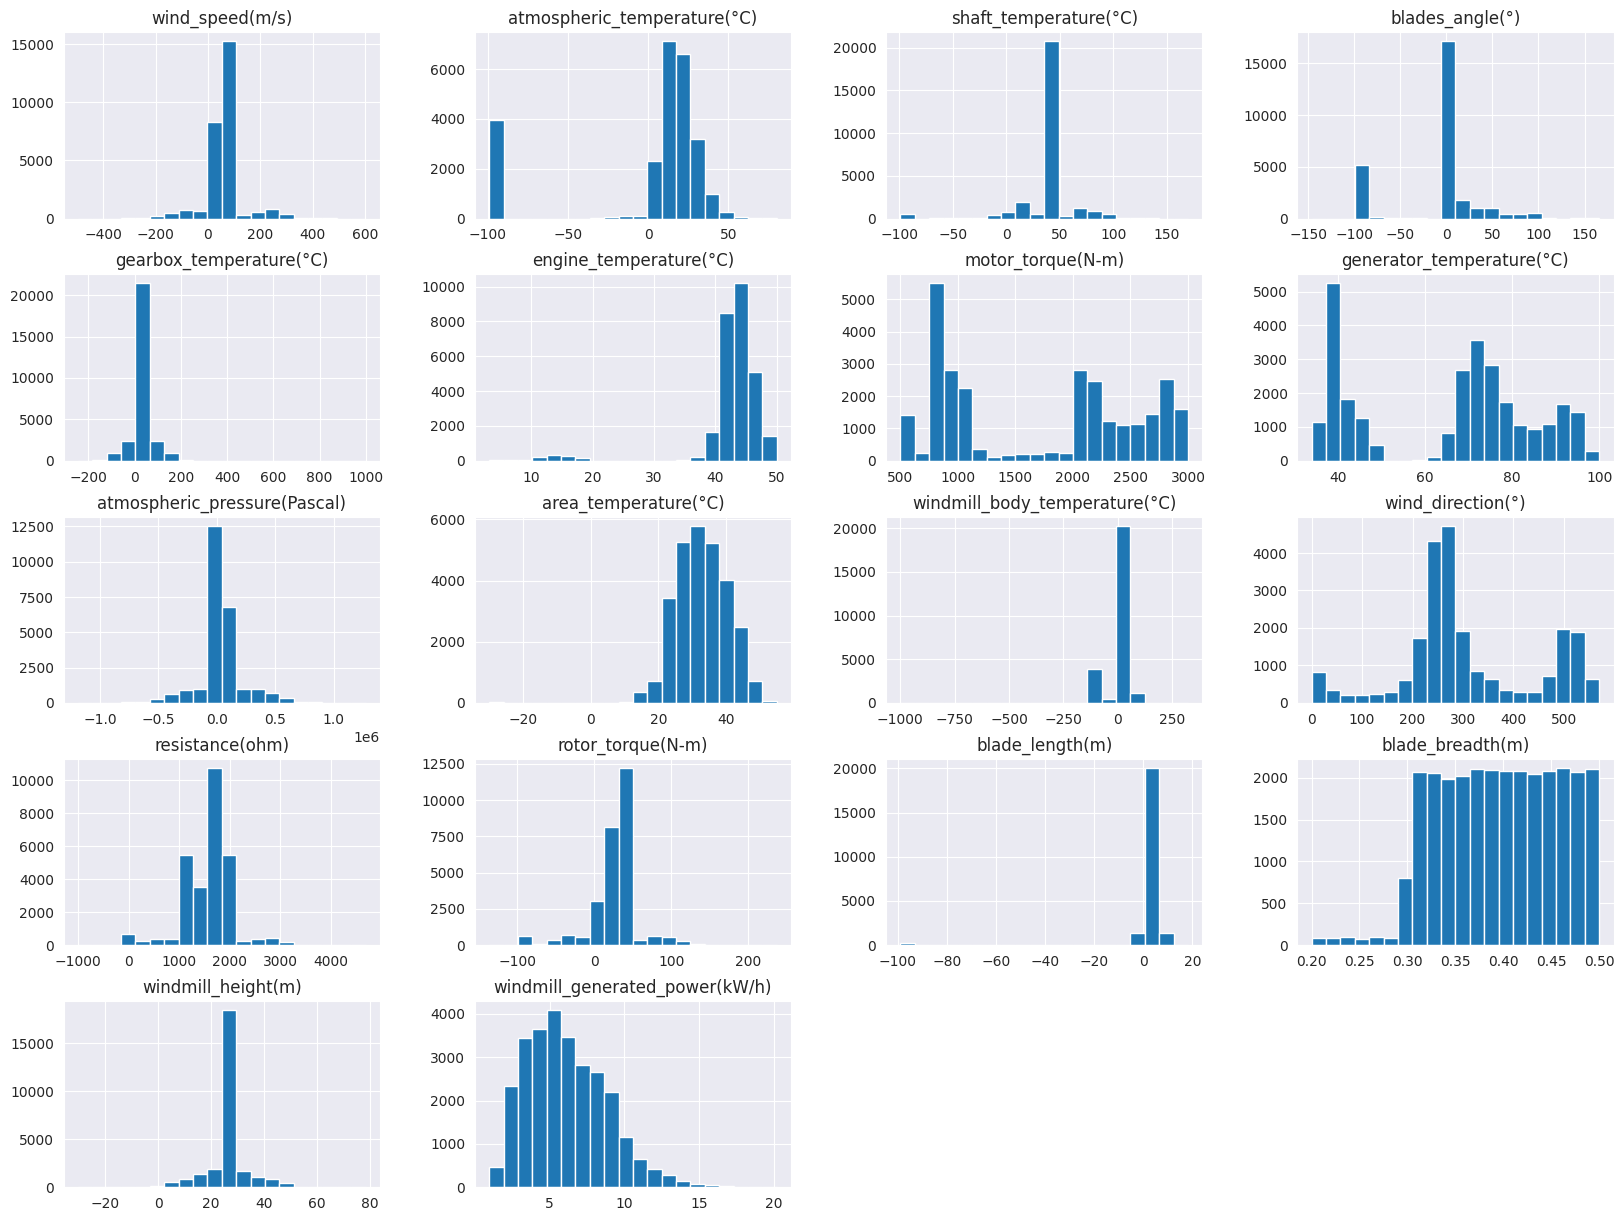

In [8]:
_ = train_df.hist(bins=20, figsize=(20, 15))

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(train_df["atmospheric_temperature(°C)"], bins=30)
plt.savefig("figures/ch6_atmospheric_temperature.png", dpi=600)

In [ ]:
sns.histplot(train_df["turbine_status"])

In [ ]:
sns.histplot(train_df["cloud_level"])

### Missing and duplicated values

In [9]:
train_df.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

In [10]:
train_df[train_df.duplicated()]

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),...,windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)


In [11]:
train_df.nunique()

tracking_id                       28200
datetime                          28200
wind_speed(m/s)                   27727
atmospheric_temperature(°C)       20809
shaft_temperature(°C)             27625
blades_angle(°)                   22830
gearbox_temperature(°C)           27911
engine_temperature(°C)            28188
motor_torque(N-m)                 27660
generator_temperature(°C)         28187
atmospheric_pressure(Pascal)      25492
area_temperature(°C)              28170
windmill_body_temperature(°C)     21893
wind_direction(°)                 22984
resistance(ohm)                   27365
rotor_torque(N-m)                 25945
turbine_status                       14
cloud_level                           3
blade_length(m)                   22833
blade_breadth(m)                  28200
windmill_height(m)                27657
windmill_generated_power(kW/h)    27988
dtype: int64

### Data Cleaning

In [12]:
def clean_outliers(frame, feature):
    column_data = frame[feature]
    column_data = column_data[~np.isnan(column_data)]

    mean, std = np.mean(column_data), np.std(column_data)

    lower_bound = mean - std * 3
    upper_bound = mean + std * 3
    frame.loc[((frame[feature] < lower_bound) | (frame[feature] > upper_bound))] = np.nan
    return frame

def clean_data(frame, is_test=False):
    for f in numerical_columns:
        if is_test and f == "windmill_generated_power(kW/h)":
            continue
        frame.loc[frame[f] == -99.0, f] = np.nan
        frame.loc[frame[f] == 99.0, f] = np.nan
        frame.loc[frame[f] == -999.0, f] = np.nan
        frame.loc[frame[f] == 999.0, f] = np.nan

        frame = clean_outliers(frame, f)

    frame.loc[frame["wind_speed(m/s)"] < 0, "wind_speed(m/s)"] = 0
    frame.loc[frame["wind_speed(m/s)"] > 113, "wind_speed(m/s)"] = 113

    frame.loc[frame["blade_length(m)"] < 0, "blade_length(m)"] = 0
    frame.loc[frame["windmill_height(m)"] < 0, "windmill_height(m)"] = 0
    frame.loc[frame["resistance(ohm)"] < 0, "resistance(ohm)"] = 0

    for f in frame.columns:
        if is_test and f == "windmill_generated_power(kW/h)":
            continue
        if f in numerical_columns:
            frame[f].fillna(frame[f].median(), inplace=True)
        else:
            frame[f].fillna(frame[f].mode()[0], inplace=True)
    return frame

In [13]:
for feature in categorical_columns:
    train_df[feature] = pd.Series(train_df[feature], dtype="category")

In [14]:
train_df["datetime"] = pd.to_datetime(train_df[ "datetime"])

In [15]:
train_df = clean_data(train_df)

In [16]:
train_df.isnull().sum()

tracking_id                       0
datetime                          0
wind_speed(m/s)                   0
atmospheric_temperature(°C)       0
shaft_temperature(°C)             0
blades_angle(°)                   0
gearbox_temperature(°C)           0
engine_temperature(°C)            0
motor_torque(N-m)                 0
generator_temperature(°C)         0
atmospheric_pressure(Pascal)      0
area_temperature(°C)              0
windmill_body_temperature(°C)     0
wind_direction(°)                 0
resistance(ohm)                   0
rotor_torque(N-m)                 0
turbine_status                    0
cloud_level                       0
blade_length(m)                   0
blade_breadth(m)                  0
windmill_height(m)                0
windmill_generated_power(kW/h)    0
dtype: int64

In [17]:
train_df.describe().T.style.bar(subset=['mean'])

,count,mean,std,min,25%,50%,75%,max
wind_speed(m/s),28200.000000,75.644704,34.606315,0.000000,46.675803,93.484918,94.708828,113.000000
atmospheric_temperature(°C),28200.000000,19.553261,6.808377,-11.503411,17.759784,18.985355,20.291577,50.126527
shaft_temperature(°C),28200.000000,43.860188,13.879518,-13.543336,42.820135,43.892730,44.989148,99.229332
blades_angle(°),28200.000000,5.098547,14.405968,-62.803175,-0.392053,0.330372,1.427127,84.170832
gearbox_temperature(°C),28200.000000,43.461986,30.708799,-78.868195,41.991604,43.485888,45.001927,164.049034
engine_temperature(°C),28200.000000,43.782776,1.911877,35.410772,42.710016,43.680546,44.738353,49.945700
motor_torque(N-m),28200.000000,1849.688672,717.159595,500.000000,1015.616746,2072.705216,2288.337348,2992.737332
generator_temperature(°C),28200.000000,67.769198,16.937847,33.924944,65.900362,71.605100,76.178725,100.000000
atmospheric_pressure(Pascal),28200.000000,39718.755280,137396.043531,-513777.950907,17188.252363,17990.718123,30196.070336,614773.885260
area_temperature(°C),28200.000000,33.356577,6.129772,11.483073,29.734894,33.203551,36.747936,55.000000


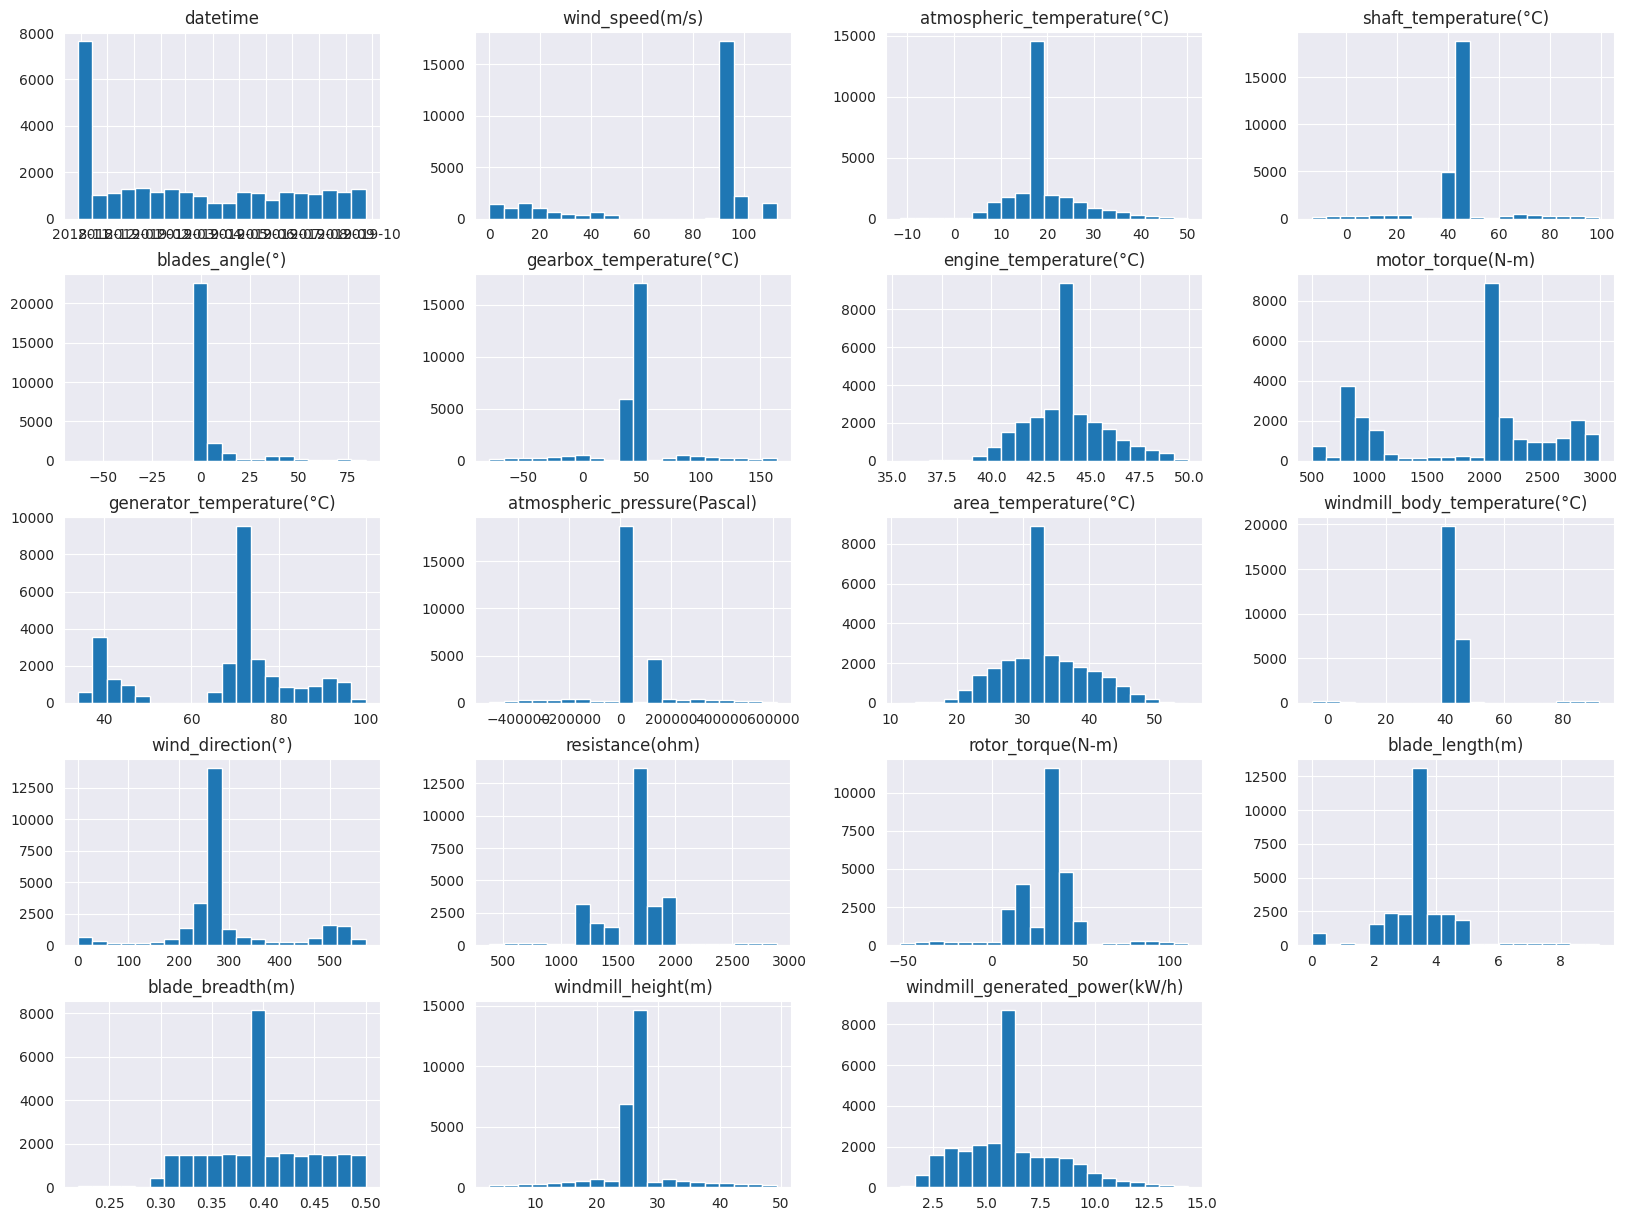

In [18]:
_ = train_df.hist(bins=20, figsize=(20, 15))

## Feature Engineering

In [19]:
def prepare_data(frame):
    frame["datetime"] = pd.to_datetime(frame[ "datetime"])
    frame["date_year"] = frame["datetime"].dt.year
    frame["date_month"] = frame["datetime"].dt.month
    frame["date_day"] = frame["datetime"].dt.day
    frame["date_hour"] = frame["datetime"].dt.hour
    frame = frame.drop(columns=["tracking_id", "datetime", "generator_temperature(°C)"], axis=1)
    for feature in categorical_columns:
        frame[feature] = pd.Series(frame[feature], dtype="category")
    return frame

In [20]:
train_df = prepare_data(train_df)

## Exploratory Data Analysis

### Correlation

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(method="spearman"), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig("figures/ch6_correlations.png", dpi=600)

In [ ]:
train_df.groupby("cloud_level")["windmill_generated_power(kW/h)"].mean().plot.bar()
plt.title('Cloud Level')
plt.xticks(rotation=0)
plt.savefig("figures/ch6_cloud_level.png", dpi=600)

In [ ]:
train_df.groupby("turbine_status")["windmill_generated_power(kW/h)"].mean().plot.bar()

In [ ]:
sns.scatterplot(x='motor_torque(N-m)',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)

In [ ]:
sns.scatterplot(x='wind_speed(m/s)',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)

In [ ]:
sns.scatterplot(x='blades_angle(°)',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)
plt.title('Power Generated by Blade Angle')
plt.savefig("figures/ch6_blade_angle.png", dpi=600)

In [ ]:
sns.scatterplot(x='date_hour',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)

In [ ]:
sns.scatterplot(x='date_month',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)
plt.title('Power Generated by Month')
plt.savefig("figures/ch6_month.png", dpi=600)

In [ ]:
sns.scatterplot(x='wind_direction(°)',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)

In [ ]:
sns.scatterplot(x='atmospheric_temperature(°C)',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)

In [ ]:
sns.scatterplot(x='blade_length(m)',y='windmill_generated_power(kW/h)',hue='cloud_level',data=train_df)

# Modeling

In [21]:
train_df

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),...,turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),date_year,date_month,date_day,date_hour
0,94.820023,18.985355,41.723019,-0.903423,82.410573,42.523015,2563.124522,103402.961872,26.897875,43.362214,...,BA,Medium,2.217542,0.314065,24.281689,6.766521,2019,8,4,14
1,113.000000,27.764785,43.892730,0.330372,44.104919,46.258870,2372.384119,17030.904078,39.801469,43.362214,...,A2,Medium,4.210346,0.448494,27.262139,5.966275,2018,11,5,10
2,95.484724,18.985355,41.855473,12.652763,42.322098,42.878552,1657.169646,16125.927107,36.116065,45.033197,...,ABC,Medium,2.719475,0.302321,27.366127,2.874342,2019,9,14,14
3,93.484918,18.985355,43.892730,0.330372,43.485888,43.680546,2072.705216,17990.718123,33.203551,43.362214,...,A,Low,3.494577,0.399186,25.979805,5.859446,2018,10,28,20
4,10.722890,18.985355,41.981183,1.715696,-17.616459,43.469852,781.695419,114468.169007,34.572941,43.362214,...,AAA,Medium,3.494577,0.453374,27.971650,3.519074,2019,5,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28195,94.765699,23.576793,45.399352,5.377222,-1.085171,48.528248,2791.600990,19428.725079,45.429230,44.242269,...,BB,Medium,2.774335,0.418299,24.590801,9.587934,2019,1,2,2
28196,93.484918,18.985355,43.892730,0.330372,43.485888,43.680546,2072.705216,17990.718123,33.203551,43.362214,...,A,Low,3.494577,0.399186,25.979805,5.859446,2018,10,28,20
28197,94.160463,28.674296,45.004213,9.550358,49.377706,44.042632,2801.657374,19083.881449,45.129442,43.576510,...,D,Medium,3.494577,0.380264,28.533850,11.096599,2018,12,12,2
28198,95.430377,26.560254,48.032624,3.051389,81.443896,44.821365,2760.647280,18360.785707,45.603927,44.973415,...,BCB,Low,3.001855,0.346447,47.747269,9.373239,2019,2,3,19


In [22]:
X = train_df.drop(columns=["windmill_generated_power(kW/h)"], axis=1)
y = train_df["windmill_generated_power(kW/h)"]

## Baseline Model (Linear Regression)

In [23]:
X_dummies = pd.get_dummies(X)
linear = LinearRegression()
scores = cross_val_score(linear, X_dummies, y)
print(f"R^2: {scores.mean()}")
scores = cross_val_score(linear, X_dummies, y, scoring="neg_mean_squared_error")
print(f"MSE: {-1 * scores.mean()}")

R^2: 0.5582015322741734
MSE: 2.2609008234557604


In [ ]:
forest = RandomForestRegressor()
X_dummies = pd.get_dummies(X)
scores = cross_val_score(forest, X_dummies, y)
print(f"R^2: {scores.mean()}")
scores = cross_val_score(forest, X_dummies, y, scoring="neg_mean_squared_error")
print(f"MSE: {-1 * scores.mean()}")

In [24]:
lgbm = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
scores = cross_val_score(lgbm, X, y)
print(f"R^2: {scores.mean()}")
scores = cross_val_score(lgbm, X, y, scoring="neg_mean_squared_error")
print(f"MSE: {-1 * scores.mean()}")

R^2: 0.9562329387573516
MSE: 0.2239793008674844


In [25]:
model = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
model = model.fit(X, y)

In [ ]:
ax = lgb.plot_importance(model)
ax

In [ ]:
ax.figure.savefig("figures/ch6_feature_importance.png", dpi=600, bbox_inches='tight')

In [26]:
X = X.drop(columns=["blades_angle(°)", "motor_torque(N-m)"], axis=1)

In [27]:
lgbm = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
scores = cross_val_score(lgbm, X, y)
print(f"R^2: {scores.mean()}")
scores = cross_val_score(lgbm, X, y, scoring="neg_mean_squared_error")
print(f"MSE: {-1 * scores.mean()}")

R^2: 0.9186188244697725
MSE: 0.41653951643580023


## Parameter Optimization

In [ ]:
def objective(trial):
    boosting_type = trial.suggest_categorical("boosting_type", ["dart", "gbdt"])
    lambda_l1 = trial.suggest_float(
        'lambda_l1', 1e-8, 10.0, log=True),
    lambda_l2 = trial.suggest_float(
        'lambda_l2', 1e-8, 10.0, log=True),
    num_leaves = trial.suggest_int(
        'num_leaves', 2, 256),
    feature_fraction = trial.suggest_float(
        'feature_fraction', 0.4, 1.0),
    bagging_fraction = trial.suggest_float(
        'bagging_fraction', 0.4, 1.0),
    bagging_freq = trial.suggest_int(
        'bagging_freq', 1, 7),
    min_child_samples = trial.suggest_int(
        'min_child_samples', 5, 100),
    learning_rate = trial.suggest_float(
        "learning_rate", 0.0001, 0.5, log=True),
    max_bin = trial.suggest_int(
        "max_bin", 128, 512, 32)
    n_estimators = trial.suggest_int(
        "n_estimators", 40, 400, 20)

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "mean_squared_error")

    model = lgb.LGBMRegressor(
        force_row_wise=True,
        boosting_type=boosting_type,
        n_estimators=n_estimators,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        min_child_samples=min_child_samples,
        learning_rate=learning_rate,
        max_bin=max_bin,
        callbacks=[pruning_callback],
        verbose=-1)
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error")
    return scores.mean()

In [54]:
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner(
    min_resource=20, max_resource=400, reduction_factor=3)

study = optuna.create_study(
    direction='maximize', sampler=sampler,
    pruner=pruner
)
study.optimize(objective, n_trials=200, gc_after_trial=True, n_jobs=-1)

[I 2023-09-05 08:51:36,420] A new study created in memory with name: no-name-28799197-954f-4592-9580-2f68889e1bbd
[I 2023-09-05 08:51:59,041] Trial 1 finished with value: -3.6684248587804937 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.030279449524208638, 'lambda_l2': 2.5502873919287836e-07, 'num_leaves': 3, 'feature_fraction': 0.8103071915016493, 'bagging_fraction': 0.6246594816367188, 'bagging_freq': 5, 'min_child_samples': 75, 'learning_rate': 0.0014070826668932887, 'max_bin': 192, 'n_estimators': 380}. Best is trial 1 with value: -3.6684248587804937.
[I 2023-09-05 08:52:35,466] Trial 2 finished with value: -9.5286244408489 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.1167892117568956, 'lambda_l2': 0.6831727881566659, 'num_leaves': 94, 'feature_fraction': 0.7987861343668985, 'bagging_fraction': 0.5534828947798314, 'bagging_freq': 3, 'min_child_samples': 89, 'learning_rate': 0.0007254771657205319, 'max_bin': 224, 'n_estimators': 80}. Best is trial 1 with value

In [ ]:
print(study.best_trial)

## Train model using best parameters

In [28]:
model = lgb.LGBMRegressor(
        force_row_wise=True,
        boosting_type='dart',
        n_estimators=240,
        lambda_l1=6.537731940969165e-08,
        lambda_l2=1.857030272070365,
        num_leaves=172,
        feature_fraction=0.5872765526723429,
        bagging_fraction=0.7184755087819652,
        bagging_freq=1,
        min_child_samples=14,
        learning_rate=0.1506803350286365,
        max_bin=384,
        verbose=-1
)
scores = cross_val_score(model, X, y)
print(f"R^2: {scores.mean()}")
scores = cross_val_score(model, X_dummies, y, scoring="neg_mean_squared_error")
print(f"MSE: {-1 * scores.mean()}")

[LightGBM] [Warning] bagging_fraction is set=0.7184755087819652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7184755087819652
[LightGBM] [Warning] lambda_l1 is set=6.537731940969165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537731940969165e-08
[LightGBM] [Warning] feature_fraction is set=0.5872765526723429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5872765526723429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.857030272070365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.857030272070365
[LightGBM] [Warning] bagging_fraction is set=0.7184755087819652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7184755087819652
[LightGBM] [Warning] lambda_l1 is set=6.537731940969165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537731940969165e-08
[LightGBM] [Warning] feature_fract

In [29]:
model = lgb.LGBMRegressor(
        force_row_wise=True,
        boosting_type='dart',
        n_estimators=240,
        lambda_l1=6.537731940969165e-08,
        lambda_l2=1.857030272070365,
        num_leaves=172,
        feature_fraction=0.5872765526723429,
        bagging_fraction=0.7184755087819652,
        bagging_freq=1,
        min_child_samples=14,
        learning_rate=0.1506803350286365,
        max_bin=384,
        verbose=-1
)
model = model.fit(X, y)

[LightGBM] [Warning] bagging_fraction is set=0.7184755087819652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7184755087819652
[LightGBM] [Warning] lambda_l1 is set=6.537731940969165e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.537731940969165e-08
[LightGBM] [Warning] feature_fraction is set=0.5872765526723429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5872765526723429
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.857030272070365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.857030272070365


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

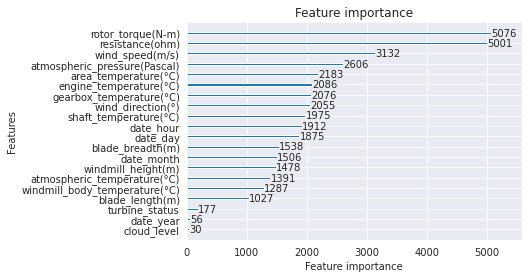

In [48]:
lgb.plot_importance(model)

### Saving the model

In [32]:
joblib.dump(model, "wind_turbine_model.pkl")

['wind_turbine_model.pkl']

In [33]:
def make_predictions(data):
    model = joblib.load("wind_turbine_model.pkl")
    return model.predict(data)

In [34]:
pred_data = prepare_data(pd.read_csv("wind-turbine/test.csv"))
pred_data = pred_data.drop(columns=["blades_angle(°)", "motor_torque(N-m)"], axis=1)
make_predictions(pred_data)

array([2.4785935 , 2.33773871, 3.36784619, ..., 4.8384808 , 5.97371378,
       9.37676575])